### Importações


In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

import re

sns.set_style("whitegrid")

#### Coleta dos dados


In [36]:
_df_train = pd.read_csv("train.csv")
_df_test = pd.read_csv("test.csv")
df_titanic = pd.concat([_df_train, _df_test], ignore_index=True)

### Funções

-   _check_null_values_: Verifica se existem valores nulos em todas as colunas (exceto a coluna "Survived")
-   _plot_graphs_: _Plota_ gráficos


In [37]:
def check_null_values(df: pd.DataFrame, ignorecolumns=["Survived"]):
    if df.isna().sum().drop(ignorecolumns).gt(0).any():
        for col in df.columns:
            if col not in ignorecolumns:
                null_values = df[col].isnull().sum()
                if null_values == 0:
                    continue
                null_percent = null_values / df.shape[0] * 100
                print(
                    f'Total de valores nulos da coluna "{col}": {null_values} ({null_percent:.2f}%)'
                )
    else:
        print(f"Não há valores nulos no Dataframe.")


def plot_graphs(df: pd.DataFrame, columns: list[tuple], fs=(12, 9)):
    """
    columns:
        Lista de tuplas de comprimento 2 onde:
        - Primeiro elemento = nome da coluna
        - Segundo elemento = tipo de plot
    """
    rows = int(len(columns) if len(columns) % 2 != 0 else len(columns) / 2)
    cols = int(1 if len(columns) % 2 != 0 else 2)
    _, axes = plt.subplots(rows, cols, figsize=fs, squeeze=False)
    plt.subplots_adjust(hspace=0.25, wspace=0.25)
    for title in range(axes.shape[0]):
        for y in range(axes.shape[1]):
            col = columns.pop(0)
            col_name = col[0]
            plot_type = col[1]
            match plot_type:
                case "count":
                    sns.countplot(df, x=col_name, hue="Survived", ax=axes[title, y])
                case "hist":
                    sns.histplot(df[col_name], kde=True, ax=axes[title, y])
                case _:
                    raise AttributeError(
                        f'Escolha um tipo de gráfico que deseja gerar para a coluna "{col_name}": [count, hist]'
                    )

### Análise dos dados

Vamos analisar quantos valores nulos existem em cada coluna do dataframe.


Total de valores nulos da coluna "Age": 263 (20.09%)
Total de valores nulos da coluna "Fare": 1 (0.08%)
Total de valores nulos da coluna "Cabin": 1014 (77.46%)
Total de valores nulos da coluna "Embarked": 2 (0.15%)


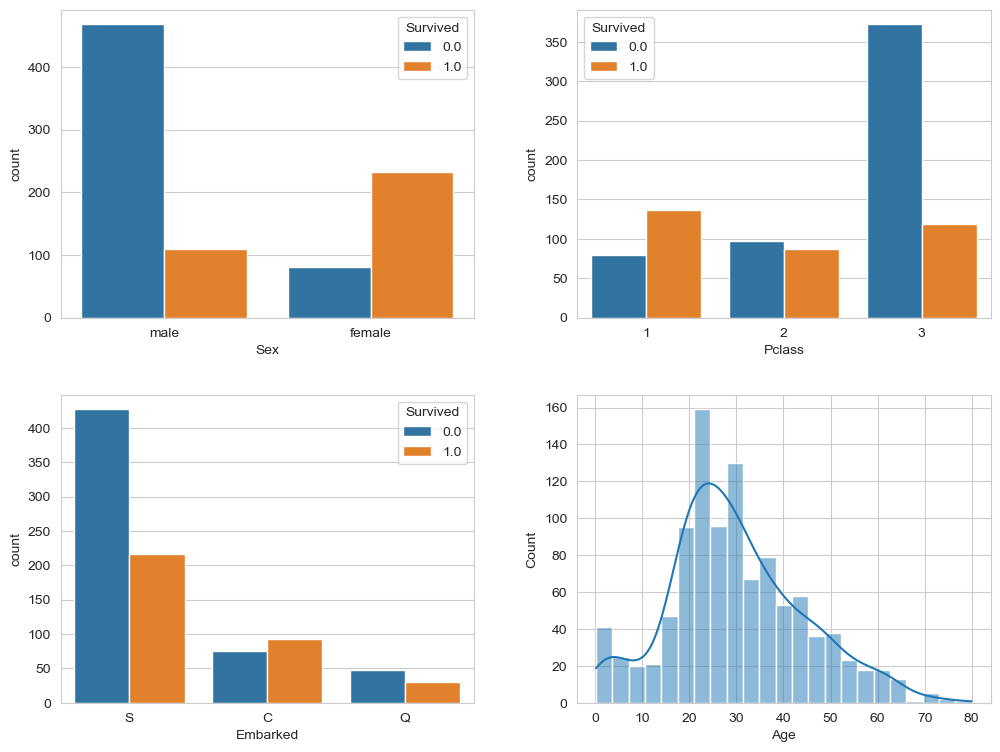

In [38]:
check_null_values(df_titanic)

cols = []
[cols.append((c, "count")) for c in ["Sex", "Pclass", "Embarked"]]
cols.append(("Age", "hist"))
plot_graphs(df_titanic, cols)

### Pré-processamento de dados

Com base nas análises realizadas, há algumas colunas com valores nulos:

---

-   Age (263 valores nulos - 20.09%)
    -   Para preencher as idades faltantes, iremos utilizar os títulos presente nos nomes dos passageiros.
        -   Solução: Criaremos uma coluna chamada "Title" que terá o título de cada passageiro, e para os passageiros com idade nula, iremos atribuir a média das idades do grupo em que ela pertencem.
        -   Exemplo: Master é um título atribuído à crianças.
            -   Com base nisto, para todos os passageiros com título "Master" com idade nulas nós iremos preencher com a média das idades do grupo "Master".

---

-   Fare (1 valor nulo - 0.08%)
    -   Solução: Usando a classe desta pessoa, iremos atribuir a média da tarifa das pessoas

---

-   Cabin (1014 valores nulos - 77.46%)
    -   A quantidade de valores nulos é extremamente elevada, portanto iremos _dropar_ esta coluna

---

-   Embarked (2 valores nulos - 0.15%)
    1. Vamos calcular a média das classes de cada portão de embarque:
       | Embarque | Media (Pclass) |
       |:--------:|:--------------:|
       | S | 2.35 |
       | C | 1.85 |
       | Q | 2.89 |
    2. Iremos calcular a diferença entre a média total das classes (Média total = 2.29) com cada uma das médias calculadas dos grupos de embarque e escolheremos a que tiver a menor diferença:
       | Embarque | Media (Pclass) | Resultado |
       |:--------:|:--------------:|:-----------------------------:|
       | S | 2.35 | \| 2.29 - 2.35 \| = 0.06 |
       | C | 1.85 | \| 2.29 - 1.85 \| = 0.44 |
       | Q | 2.89 | \| 2.29 - 2.89 \| = 0.6 |


In [39]:
def fillna_age(df: pd.DataFrame):
    if df_titanic["Age"].isna().any():
        df_titanic["Title"] = df_titanic["Name"].apply(
            lambda name: re.findall(r", ([^.]+)\.", name)[0]
        )
        df_titanic["Title"] = [
            t if t in ["Mr", "Mrs", "Miss", "Master"] else "Person"
            for t in df_titanic["Title"]
        ]
        print(
            f'\nTotal de valores nulos encontrados na coluna "Age": {df_titanic["Age"].isna().sum()}'
        )
        for title in df[df["Age"].isna()]["Title"].unique():
            mean = round(df[df["Title"].eq(title)]["Age"].mean(), 1)
            df.loc[df["Age"].isna() & df["Title"].eq(title), ["Age"]] = mean
        print(f'Valores nulos da coluna "Age" foram preenchidos com sucesso!')
    else:
        print(f'Nenhum valor nulo foi encontrado na coluna "Age".')


def fillna_embarked(df: pd.DataFrame):
    min_diff = None
    embarked = None
    diff = None
    PCLASSMEAN = round(df["Pclass"].mean(), 2)
    if df_titanic["Embarked"].isna().any():
        print(
            f'\nTotal de valores nulos encontrados na coluna Embarked: {df_titanic["Embarked"].isna().sum()}\n'
        )
        for embark in df[df["Embarked"].notna()]["Embarked"].unique():
            mean = round(df[df["Embarked"] == embark]["Pclass"].mean(), 2)
            diff = abs(round(PCLASSMEAN - mean, 2))
            print(f'Média das classes do embarque "{embark}": {mean}')
            print(f"Diferença: | {PCLASSMEAN} - {mean} | = {diff}\n")
            if min_diff is None or min_diff > diff:
                min_diff = diff
                embarked = embark
        print(
            f'A menor diferença encontrada foi do embarked tipo "{embarked}" ({min_diff})'
        )
        df["Embarked"].fillna(embarked, inplace=True)
        print(f'Valores nulos da coluna "Embarked" foram preenchidos com sucesso!')
    else:
        print(f'Nenhum valor nulo foi encontrado na coluna "Embarked".')


def fillna_fare(df: pd.DataFrame):
    if df["Fare"].isna().any():
        print(
            f'\nTotal de valores nulos encontrados na coluna "Fare": {df["Fare"].isna().sum()}'
        )
        for pclass in df[df["Fare"].isna()]["Pclass"].unique():
            for embarked in df[df["Fare"].isna()]["Embarked"].unique():
                mean = round(
                    df[df["Pclass"].eq(pclass) & df["Embarked"].eq(embarked)][
                        "Fare"
                    ].mean(),
                    4,
                )
                df.loc[
                    df["Fare"].isna()
                    & df["Pclass"].eq(pclass)
                    & df["Embarked"].eq(embarked),
                    ["Fare"],
                ] = mean
        print(f'Valores nulos da coluna "Fare" foram preenchidos com sucesso!')
    else:
        print(f'Nenhum valor nulo foi encontrado na coluna "Fare".')


fillna_age(df_titanic)
fillna_embarked(df_titanic)
fillna_fare(df_titanic)

df_titanic.drop("Cabin", axis=1, inplace=True, errors="ignore")

df_titanic["FamilySize"] = df_titanic["Parch"] + df_titanic["SibSp"] + 1


Total de valores nulos encontrados na coluna "Age": 263
Valores nulos da coluna "Age" foram preenchidos com sucesso!

Total de valores nulos encontrados na coluna Embarked: 2

Média das classes do embarque "S": 2.35
Diferença: | 2.29 - 2.35 | = 0.06

Média das classes do embarque "C": 1.85
Diferença: | 2.29 - 1.85 | = 0.44

Média das classes do embarque "Q": 2.89
Diferença: | 2.29 - 2.89 | = 0.6

A menor diferença encontrada foi do embarked tipo "S" (0.06)
Valores nulos da coluna "Embarked" foram preenchidos com sucesso!

Total de valores nulos encontrados na coluna "Fare": 1
Valores nulos da coluna "Fare" foram preenchidos com sucesso!


### Processamento de Dados


In [75]:
survived = df_titanic["Survived"]
age = df_titanic["Age"]
sibsp = df_titanic["SibSp"]
parch = df_titanic["Parch"]
fare = df_titanic["Fare"]
familysize = df_titanic["FamilySize"]
sex = pd.get_dummies(df_titanic["Sex"], prefix="Sex", dtype=int, drop_first=True)
pclass = pd.get_dummies(
    df_titanic["Pclass"], prefix="Pclass", dtype=int, drop_first=True
)
title = pd.get_dummies(df_titanic["Title"], prefix="Title", dtype=int, drop_first=True)
embarked = pd.get_dummies(
    df_titanic["Embarked"], prefix="Embarked", dtype=int, drop_first=True
)

df = pd.concat(
    [survived, age, sibsp, parch, familysize, fare, sex, pclass, title, embarked],
    axis=1,
)

index_train = len(_df_train)
index_test = len(df_titanic) - len(_df_test)

df_train = df[:index_train].copy()
df_test = df[index_test:].copy()

df_train["Survived"] = df_train["Survived"].astype(int)

X_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]

X_test = df_test.drop("Survived", axis=1)
y_test = None


def func_acuracia(algorithm, X_train, y_train, cv):
    model = algorithm.fit(X_train, y_train)
    accuracy = round(model.score(X_train, y_train) * 100, 2)
    train_pred = model_selection.cross_val_predict(
        algorithm, X_train, y_train, cv=cv, n_jobs=-1
    )
    accuracy_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return accuracy, accuracy_cv

In [105]:
class Model:

    algorithm = None
    name = None
    accuracy = None
    accuracy_cv = None

    def __init__(self, name, algorithm):
        self.name = name
        self.algorithm = algorithm


models: dict[str, Model] = {}
models["Linear SVC"] = Model("Linear SVC", LinearSVC(dual=False))
models["Logistic Regression"] = Model("Logistic Regression", LogisticRegression(max_iter=1000))
models["K-Neighbors Classifier"] = Model("K-Neighbors Classifier", KNeighborsClassifier())
models["Random Forest Classifier"] = Model("Random Forest Classifier", RandomForestClassifier())
models["Decision Tree Classifier"] = Model("Decision Tree Classifier", DecisionTreeClassifier())
models["Gaussian Naive Bayes"] = Model("Gaussian Naive Bayes", GaussianNB())
models["Stochastic Gradient Descent"] = Model("Stochastic Gradient Descent", SGDClassifier())
models["Gradient Boosting Classifier"] = Model("Gradient Boosting Classifier", GradientBoostingClassifier())

best_model = None
best_acc_cv = None

for s, m in models.items():
    accuracy, accuracy_cv = func_acuracia(m.algorithm, X_train, y_train, 10)
    m.accuracy = accuracy
    m.accuracy_cv = accuracy_cv
    if best_acc_cv is None or best_acc_cv < m.accuracy_cv:
        best_acc_cv = m.accuracy_cv
        best_model = s

print(f'O modelo com melhor acurácia foi: {best_model} (Acurácia Validação Cruzada: {best_acc_cv})')

O modelo com melhor acurácia foi: Gradient Boosting Classifier (Acurácia Validação Cruzada: 83.16)


In [108]:
params = dict(
    max_depth=[n for n in range(1, 5)],
    min_samples_split=[n for n in range(2, 6)],
    min_samples_leaf=[n for n in range(2, 6)],
    n_estimators=[n for n in range(10, 50, 10)],
)
gbc = models["Gradient Boosting Classifier"].algorithm
gbc_cv = GridSearchCV(gbc, params, cv=10)
gbc_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 20, 30, 40]})

,Survived,Age,SibSp,Parch,FamilySize,Fare,Sex_male,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Person,Embarked_Q,Embarked_S
891,NaN,34.5,0,0,1,7.8292,1,0,1,0,1,0,0,1,0
892,NaN,47.0,1,0,2,7.0000,0,0,1,0,0,1,0,0,1
893,NaN,62.0,0,0,1,9.6875,1,1,0,0,1,0,0,1,0
894,NaN,27.0,0,0,1,8.6625,1,0,1,0,1,0,0,0,1
895,NaN,22.0,1,1,3,12.2875,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,32.3,0,0,1,8.0500,1,0,1,0,1,0,0,0,1
1305,NaN,39.0,0,0,1,108.9000,0,0,0,0,0,0,1,0,0
1306,NaN,38.5,0,0,1,7.2500,1,0,1,0,1,0,0,0,1
1307,NaN,32.3,0,0,1,8.0500,1,0,1,0,1,0,0,0,1


In [110]:
print(f'Melhor pontuação: {gbc_cv.best_score_:.2f}')
print(f'Melhores parâmetros: {gbc_cv.best_params_}')

Melhor pontuação: 0.85
Melhores parâmetros: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 40}


In [112]:
gbc_pred = gbc_cv.predict(X_test)

418

In [118]:
df_result = pd.DataFrame({'PassengerId': _df_test['PassengerId'], 'Survived': gbc_pred})
df_result['Survived'].value_counts()

Survived
0    272
1    146
Name: count, dtype: int64